# First notebook for the analysis of a basic compas run consisting of 10000 binaries. #

## General imports

In [3]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image

In [4]:
# set path to data file
path = '/home/louism/Thesis/data/COMPAS_Output_3/COMPAS_Output.h5'

# load the file
data = h5.File(path)

# inspect the data
list(data.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_Switch_Log',
 'BSE_System_Parameters',
 'Run_Details']

## Some additional functions

In [3]:
def printCompasDetails(data, *seeds, mask=()):
    """
    Function to print the full Compas output for given seeds, optionally with an additional mask
    """
    list_of_keys = list(data.keys())

    # Check if seed parameter exists - if not, just print without (e.g RunDetails)
    if ('SEED' in list_of_keys) | ('SEED>MT' in list_of_keys): # Most output files 
        #SEED>MT is a relic from older versions, but we leave this in for backwards compatibility

        # Set the seed name parameter, mask on seeds as needed, and set the index
        seedVariableName='SEED' if ('SEED' in list_of_keys) else 'SEED>MT'
        list_of_keys.remove(seedVariableName) # this is the index above, don't want to include it
    
        allSeeds = data[seedVariableName][()]
        seedsMask = np.in1d(allSeeds, seeds)
        if len(seeds) == 0: # if any seed is included, do not reset the mask
            seedsMask = np.ones_like(allSeeds).astype(bool)
        if mask == ():
            mask = np.ones_like(allSeeds).astype(bool)
        mask &= seedsMask

        df = pd.DataFrame.from_dict({param: data[param][()][mask] for param in list(data.keys())}).set_index(seedVariableName).T

    else: # No seed parameter, so do custom print for Run Details

        # Get just the keys without the -Derivation suffix - those will be a second column
        keys_not_derivations = []
        for key in list_of_keys:
            if '-Derivation' not in key:
                keys_not_derivations.append(key)
        
        # Some parameter values are string types, formatted as np.bytes_, need to convert back
        def convert_strings(param_array):
            if isinstance(param_array[0], np.bytes_):
                return param_array.astype(str)
            else:
                return param_array

        df_keys = pd.DataFrame.from_dict({param: convert_strings(data[param][()]) for param in keys_not_derivations }).T
        nCols = df_keys.shape[1] # Required only because if we combine RDs, we get many columns (should fix later)
        df_keys.columns = ['Parameter']*nCols
        df_drvs = pd.DataFrame.from_dict({param: convert_strings(data[param+'-Derivation'][()]) for param in keys_not_derivations }).T
        df_drvs.columns = ['Derivation']*nCols
        df = pd.concat([df_keys, df_drvs], axis=1)

    # Add units as first col
    units_dict = {key:data[key].attrs['units'].astype(str) for key in list_of_keys}
    df.insert(loc=0, column='(units)', value=pd.Series(units_dict))
    return df


In [4]:
def getMtEvents(MT):                                     
    """
    This function takes in the `BSE_RLOF` output category from COMPAS, and returns the information
    on the Mass Transfer (MT) events that happen for each seed. The events do not have to be in order, 
    either chronologically or by seed, this function will reorder them as required.
    
    OUT:
        tuple of (returnedSeeds, returnedEvents, returnedTimes)
        returnedSeeds (list): ordered list of the unique seeds in the MT file
        returnedEvents (list): list of sublists, where each sublist contains all the MT events for a given seed.
            MT event tuples take the form :
            (stellarTypePrimary, stellarTypeSecondary, isRlof1, isRlof2, isCEE)
        returnTimes (list): is a list of sublists of times of each of the MT events
    """

    mtSeeds = MT['SEED'][()]
    mtTimes = MT['Time<MT'][()]
    mtPrimaryStype = MT['Stellar_Type(1)<MT'][()]
    mtSecondaryStype = MT['Stellar_Type(2)<MT'][()]
    mtIsRlof1 = MT['RLOF(1)>MT'][()] == 1
    mtIsRlof2 = MT['RLOF(2)>MT'][()] == 1
    mtIsCEE = MT['CEE>MT'][()] == 1

    # We want the return arrays sorted by seed, so sort here.
    mtSeedsInds = np.lexsort((mtTimes, mtSeeds)) # sort by seeds then times - lexsort sorts by the last column first...
    mtSeeds = mtSeeds[mtSeedsInds]  
    mtTimes = mtTimes[mtSeedsInds]  
    mtPrimaryStype = mtPrimaryStype[mtSeedsInds]
    mtSecondaryStype = mtSecondaryStype[mtSeedsInds]
    mtIsRlof1 = mtIsRlof1[mtSeedsInds]
    mtIsRlof2 = mtIsRlof2[mtSeedsInds]
    mtIsCEE = mtIsCEE[mtSeedsInds]

    # Process the MT events

    returnedSeeds = []                                      # array of seeds - will only contain seeds that have MT events
    returnedEvents = []                                     # array of MT events for each seed in returnedSeeds
    returnedTimes = []                                      # array of times for each event in returnedEvents (for each seed in returnedSeeds)

    lastSeed = -1                                           # initialize most recently processed seed

    for seedIndex, thisSeed in enumerate(mtSeeds):          # iterate over all RLOF file entries
        thisTime = mtTimes[seedIndex]                       # time for this RLOF file entry
        thisEvent = (mtPrimaryStype[seedIndex], mtSecondaryStype[seedIndex], 
                     mtIsRlof1[seedIndex], mtIsRlof2[seedIndex], mtIsCEE[seedIndex])  # construct event tuple

        # If this is an entirely new seed:
        if thisSeed != lastSeed:                            # same seed as last seed processed?
            returnedSeeds.append(thisSeed)                  # no - new seed, record it
            returnedTimes.append([thisTime])                # initialize the list of event times for this seed
            returnedEvents.append([thisEvent])              # initialize the list of events for this seed
            lastSeed = thisSeed                             # update the latest seed

        # Add event, if it is not a duplicate
        try:
            eventIndex = returnedEvents[-1].index(thisEvent)  # find eventIndex of this particular event tuple in the array of events for this seed 
            if thisTime > returnedTimes[-1][eventIndex]:      # ^ if event is not a duplicate, this will throw a ValueError 
                returnedTimes[-1][eventIndex] = thisTime      # if event is duplicate, update time to the later of the duplicates
        except ValueError:                                    # event is not a duplicate:
            returnedEvents[-1].append(thisEvent)              # record new event tuple for this seed
            returnedTimes[-1].append(thisTime)                # record new event time for this seed

    return returnedSeeds, returnedEvents, returnedTimes       # see above for description

In [5]:
def getSnEvents(SN):                                     
    """
    This function takes in the `BSE_Supernovae` output category from COMPAS, and returns the information
    on the Supernova (SN) events that happen for each seed. The events do not have to be in order chronologically,
    this function will reorder them as required.
    
    OUT:
        tuple of (returnedSeeds, returnedEvents, returnedTimes)     
        returnedSeeds (list): ordered list of all the unique seeds in the SN file
        returnedEvents (list): list of sublists, where each sublist contains all the SN events for a given seed.
            SN event tuples take the form :
            (stellarTypeProgenitor, stellarTypeRemnant, whichStarIsProgenitor, isBinaryUnbound)
        returnedTimes (list): is a list of sublists of times of each of the SN events
    """
    
    snSeeds = SN['SEED'][()]
    snTimes = SN['Time'][()]
    snProgStype = SN['Stellar_Type_Prev(SN)'][()]
    snRemnStype = SN['Stellar_Type(SN)'][()]
    snWhichProg = SN['Supernova_State'][()]
    snIsUnbound = SN['Unbound'][()] == 1

    # We want the return arrays sorted by seed, so sort here.
    snSeedsInds = np.lexsort((snTimes, snSeeds)) # sort by seeds then times - lexsort sorts by the last column first...
    snSeeds = snSeeds[snSeedsInds]  
    snTimes = snTimes[snSeedsInds]  
    snProgStype = snProgStype[snSeedsInds]
    snRemnStype = snRemnStype[snSeedsInds]
    snWhichProg = snWhichProg[snSeedsInds]
    snIsUnbound = snIsUnbound[snSeedsInds]
    
    # Process the SN events

    returnedSeeds = []                                      # array of seeds - will only contain seeds that have SN events
    returnedEvents = []                                     # array of SN events for each seed in returnedSeeds
    returnedTimes = []                                      # array of times for each event in returnedEvents (for each seed in returnedSeeds)

    lastSeed = -1                                           # initialize most recently processed seed

    for seedIndex, thisSeed in enumerate(snSeeds):          # iterate over all SN file entries
        thisTime = snTimes[seedIndex]                       # time for this SN file entry
        thisEvent = (snProgStype[seedIndex], snRemnStype[seedIndex], 
                     snWhichProg[seedIndex], snIsUnbound[seedIndex]) # construct event tuple
               
        # If this is an entirely new seed:
        if thisSeed != lastSeed:                            # same seed as last seed processed?
            returnedSeeds.append(thisSeed)                  # no - new seed, record it
            returnedTimes.append([thisTime])                #   initialize the list of event times for this seed
            returnedEvents.append([thisEvent])              #   initialize the list of events for this seed
            lastSeed = thisSeed                             #   update the latest seed
        else:                                               # yes - second SN event for this seed
            returnedTimes[-1].append(thisTime)              #   append time at end of array
            returnedEvents[-1].append(thisEvent)            #   append event at end of array
                
    return returnedSeeds, returnedEvents, returnedTimes     # see above for description

In [6]:
def getEventHistory(h5file, exclude_null=False):
    """
    Get the event history for all seeds, including both RLOF and SN events, in chronological order.
    IN:
        h5file (h5.File() type): COMPAS HDF5 output file
        exclude_null (bool): whether or not to exclude seeds which undergo no RLOF or SN events
    OUT:
        tuple of (returnedSeeds, returnedEvents)
        returnedSeeds (list): ordered list of all seeds in the output
        returnedEvents (list): a list of the collected SN and MT events from the 
            getMtEvents and getSnEvents functions above
    """

    SP = h5file['BSE_System_Parameters']
    MT = h5file['BSE_RLOF']
    SN = h5file['BSE_Supernovae']
    allSeeds = SP['SEED'][()]                                              # get all seeds
    mtSeeds, mtEvents, mtTimes = getMtEvents(MT)                           # get MT events
    snSeeds, snEvents, snTimes = getSnEvents(SN)                           # get SN events

    numMtSeeds = len(mtSeeds)                                               # number of MT events
    numSnSeeds = len(snSeeds)                                               # number of SN events

    if numMtSeeds < 1 and numSnSeeds < 1: return []                         # no events - return empty history

    returnedSeeds = []                                                      # array of seeds - will only contain seeds that have events (of any type)
    returnedEvents = []                                                     # array of events - same size as returnedSeeds (includes event times)

    eventOrdering = ['MT', 'SN']                                            # order of preference for simultaneous events

    mtIndex = 0                                                             # index into MT events arrays
    snIndex = 0                                                             # index into SN events arrays

    if exclude_null:
        seedsToIterate = np.sort(np.unique(np.append(mtSeeds, snSeeds)))    # iterate over all the seeds that have either MT or SN events
    else:
        seedsToIterate = allSeeds
        
    idxOrdered = np.argsort(seedsToIterate)
    returnedSeeds = [None] * np.size(seedsToIterate)                        # array of seeds - will only contain seeds that have events (of any type)
    returnedEvents = [None] * np.size(seedsToIterate)                       # array of events - same size as returnedSeeds (includes event times)

    for idx in idxOrdered:
        seed = seedsToIterate[idx]
        seedEvents = []                                                     # initialise the events for the seed being processed

        # Collect any MT events for this seed, add the time of the event and the event type
        while mtIndex < numMtSeeds and mtSeeds[mtIndex] == seed:
            for eventIndex, event in enumerate(mtEvents[mtIndex]):
                seedEvents.append(('MT', mtTimes[mtIndex][eventIndex], *mtEvents[mtIndex][eventIndex]))
            mtIndex += 1

        # Collect any SN events for this seed, add the time of the event and the event type 
        while snIndex < numSnSeeds and snSeeds[snIndex] == seed:
            for eventIndex, event in enumerate(snEvents[snIndex]):
                seedEvents.append(('SN', snTimes[snIndex][eventIndex], *snEvents[snIndex][eventIndex]))
            snIndex += 1

        seedEvents.sort(key=lambda ev:(ev[1], eventOrdering.index(ev[0])))  # sort the events by time and event type (MT before SN if at the same time)

        returnedSeeds[idx] = seed                                           # record the seed in the seeds array being returned
        returnedEvents[idx] = seedEvents                                    # record the events for this seed in the events array being returned

    return returnedSeeds, returnedEvents                                    # see above for details

## Tasks:
- histogram showing amount of stripped stars
- time spent on each phase
- scatterplot of mass vs time spent as stripped star; differentiate between self-stripped and binary-stripped, differentiate betweens tars still in binary or disrupted binary

## Written functions

- code for plotting the histogram of all stellar types in the COMPAS run at ZAMS and at the end of the simulation

In [7]:
def stellar_types_histogram(data):

    bins = np.arange(0, 16 + 1.5) - 0.5
    xtix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    
    SPs = data["BSE_System_Parameters"]
    sps = printCompasDetails(SPs)

    sps_data = np.array(sps.to_numpy())

    zams_type_primary = sps_data[27][1:]
    zams_type_secundary = sps_data[28][1:]

    term_type_primary = sps_data[25][1:]
    term_type_secundary = sps_data[26][1:]
    
    fig, ax = plt.subplots(2,2, figsize=(14,10))
    
    ax[0][0].set_title("Stellar Types at ZAMS")
    
    counts00, edges00, bars00 = ax[0][0].hist(zams_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[0][0].set_ylabel("Amount")
    ax[0][0].set_xticks(xtix)
    ax[0][0].legend()
    ax[0][0].set_xlabel("Stellar Types")
    ax[0][0].bar_label(bars00)
    
    counts01, edges01, bars01 = ax[0][1].hist(zams_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[0][1].set_ylabel("Amount")
    ax[0][1].set_xticks(xtix)
    ax[0][1].legend()
    ax[0][1].set_xlabel("Stellar Types")
    ax[0][1].bar_label(bars01)
    
    ax[1][0].set_title("Final Stellar Types")
    
    counts10, edges10, bars10 = ax[1][0].hist(term_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[1][0].set_ylabel("Amount")
    ax[1][0].set_xticks(xtix)
    ax[1][0].legend()
    ax[1][0].bar_label(bars10)
    
    counts11, edges11, bars11 = ax[1][1].hist(term_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[1][1].set_ylabel("Amount")
    ax[1][1].set_xticks(xtix)
    ax[1][1].legend()
    ax[1][1].bar_label(bars11)
    ax[1][1].set_xlabel("Stellar Types")
    
    plt.show()

# Analysis

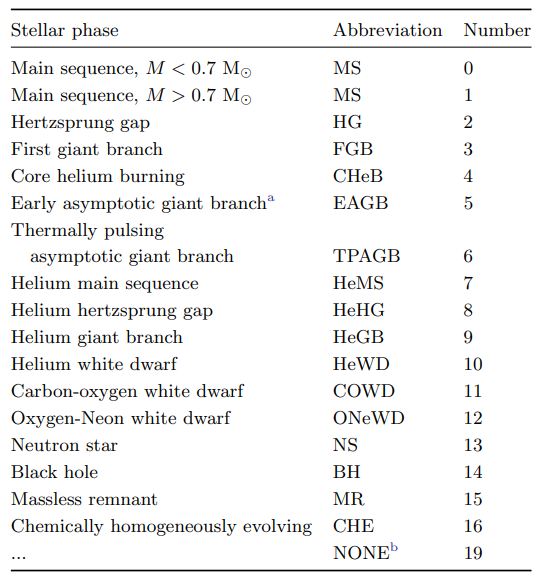

In [9]:
Image("/home/louism/Thesis/COMPAS_stellar_types.png")

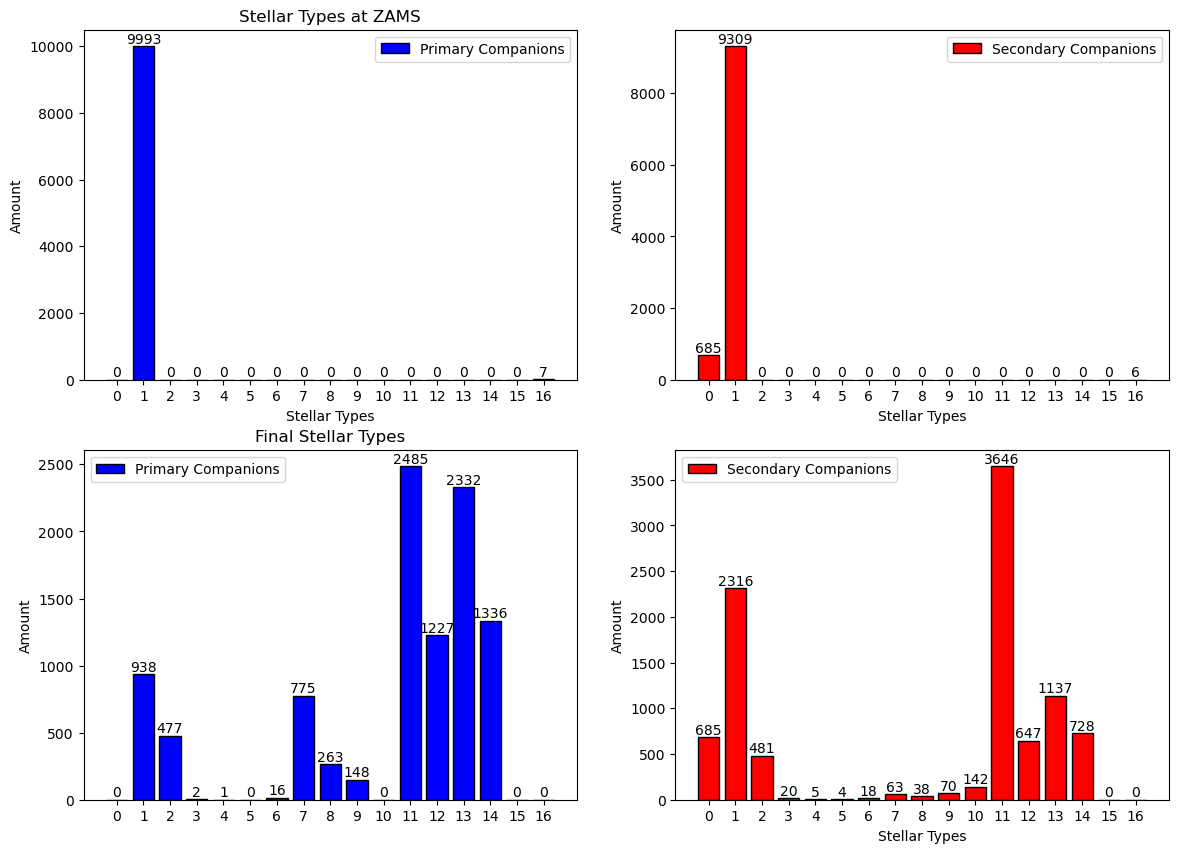

In [10]:
stellar_types_histogram(data)

In [113]:
SLs = data["BSE_Switch_Log"]
sls = printCompasDetails(SLs)
printCompasDetails(SLs, 1727965106)

SEED           (units)  1727965106  1727965106  1727965106  1727965106  \
Star_Switching       -    1.000000    1.000000    1.000000    1.000000   
Switching_From       -    1.000000    2.000000    3.000000    4.000000   
Switching_To         -    2.000000    3.000000    4.000000    5.000000   
Time               Myr   50.349652   50.519292   50.569286   56.750997   

SEED            1727965106  1727965106  1727965106  1727965106  1727965106  \
Star_Switching    1.000000    2.000000    2.000000    1.000000     2.00000   
Switching_From    5.000000    1.000000    2.000000    6.000000     3.00000   
Switching_To      6.000000    2.000000    3.000000   12.000000     4.00000   
Time             57.028599   57.101473   57.301773   57.350325    57.36777   

SEED            1727965106  1727965106  1727965106  
Star_Switching    2.000000    2.000000    2.000000  
Switching_From    4.000000    5.000000    6.000000  
Switching_To      5.000000    6.000000   12.000000  
Time             64.541047   64.878044   65.890061

In [15]:
uniqueSeeds=np.unique(SLs['SEED'][()])

In [16]:
printCompasDetails(SLs, uniqueSeeds)

SEED           (units)  1727965106  1727965106  1727965106  1727965106  \
Star_Switching       -    1.000000    1.000000    1.000000    1.000000   
Switching_From       -    1.000000    2.000000    3.000000    4.000000   
Switching_To         -    2.000000    3.000000    4.000000    5.000000   
Time               Myr   50.349652   50.519292   50.569286   56.750997   

SEED            1727965106  1727965106  1727965106  1727965106  1727965106  \
Star_Switching    1.000000    2.000000    2.000000    1.000000     2.00000   
Switching_From    5.000000    1.000000    2.000000    6.000000     3.00000   
Switching_To      6.000000    2.000000    3.000000   12.000000     4.00000   
Time             57.028599   57.101473   57.301773   57.350325    57.36777   

SEED            ...  1727975105  1727975105  1727975105  1727975105  \
Star_Switching  ...    1.000000    1.000000    1.000000    1.000000   
Switching_From  ...    3.000000    4.000000    5.000000    6.000000   
Switching_To    ...    4.000000    5.000000    6.000000   11.000000   
Time            ...   96.526298  110.223531  110.915971  112.130971   

SEED             1727975105   1727975105   1727975105   1727975105  \
Star_Switching     2.000000     2.000000     2.000000     2.000000   
Switching_From     1.000000     2.000000     3.000000     4.000000   
Switching_To       2.000000     3.000000     4.000000     5.000000   
Time            2398.307047  2456.838294  2585.039729  2585.296971   

SEED             1727975105   1727975105  
Star_Switching     2.000000     2.000000  
Switching_From     5.000000     6.000000  
Switching_To       6.000000    11.000000  
Time            2589.258543  2591.023543  

[4 rows x 77063 columns]

In [122]:
# Function to extract the base ID, handling both string and integer column names
def extract_id(col_name):
    if isinstance(col_name, int):
        return str(col_name)  # If the column name is an integer, just return it as a string
    elif isinstance(col_name, str):
        return col_name.split()[0]  # For strings, take the part before any space (i.e., the numeric part)

# Extract unique IDs by processing the column names
ids = set(extract_id(col) for col in sls.columns)

# Initialize a dictionary to store the data
binary_data = {}

# Iterate over each unique ID
for id in uniqueSeeds[0:10]:
    # Select columns corresponding to the current ID (both components 1 and 2)
    id_columns = SLs['SEED'][()] == id
    mask_comp1 = (SLs['Star_Switching'][()] == 1) & id_columns
    mask_comp2 = (SLs['Star_Switching'][()] == 2) & id_columns
    # Identify which columns correspond to component 1 and component 2 based on the first row
    #comp1 = id_columns.loc[:, id_columns.iloc[0] == 1].to_numpy()[1:]  # Component 1 data
    #comp2 = id_columns.loc[:, id_columns.iloc[0] == 2].to_numpy()[1:]  # Component 2 data

    # Store the NumPy arrays for this ID
    binary_data[id] = {
        'component_1': mask_comp1,
        'component_2': mask_comp2
    }

In [123]:
binary_data

{1727965106: {'component_1': array([ True,  True,  True, ..., False, False, False]),
  'component_2': array([False, False, False, ..., False, False, False])},
 1727965108: {'component_1': array([False, False, False, ..., False, False, False]),
  'component_2': array([False, False, False, ..., False, False, False])},
 1727965109: {'component_1': array([False, False, False, ..., False, False, False]),
  'component_2': array([False, False, False, ..., False, False, False])},
 1727965110: {'component_1': array([False, False, False, ..., False, False, False]),
  'component_2': array([False, False, False, ..., False, False, False])},
 1727965111: {'component_1': array([False, False, False, ..., False, False, False]),
  'component_2': array([False, False, False, ..., False, False, False])},
 1727965112: {'component_1': array([False, False, False, ..., False, False, False]),
  'component_2': array([False, False, False, ..., False, False, False])},
 1727965113: {'component_1': array([False, Fal

In [118]:
#for id in uniqueSeeds[0:10]:
    # Select columns corresponding to the current ID (both components 1 and 2)
id = uniqueSeeds[0]
id_columns = sls[sls.columns == id]
# Identify which columns correspond to component 1 and component 2 based on the first row
#comp1 = id_columns.loc[:, id_columns.iloc[0] == 1].to_numpy()[1:]  # Component 1 data
#comp2 = id_columns.loc[:, id_columns.iloc[0] == 2].to_numpy()[1:]  # Component 2 data

# Store the NumPy arrays for this ID
#binary_data[id] = {
 #   'component_1': comp1,
  #  'component_2': comp2
#}

ValueError: Item wrong length 77063 instead of 4.

In [111]:
sls

SEED           (units)  1727965106  1727965106  1727965106  1727965106  \
Star_Switching       -    1.000000    1.000000    1.000000    1.000000   
Switching_From       -    1.000000    2.000000    3.000000    4.000000   
Switching_To         -    2.000000    3.000000    4.000000    5.000000   
Time               Myr   50.349652   50.519292   50.569286   56.750997   

SEED            1727965106  1727965106  1727965106  1727965106  1727965106  \
Star_Switching    1.000000    2.000000    2.000000    1.000000     2.00000   
Switching_From    5.000000    1.000000    2.000000    6.000000     3.00000   
Switching_To      6.000000    2.000000    3.000000   12.000000     4.00000   
Time             57.028599   57.101473   57.301773   57.350325    57.36777   

SEED            ...  1727975105  1727975105  1727975105  1727975105  \
Star_Switching  ...    1.000000    1.000000    1.000000    1.000000   
Switching_From  ...    3.000000    4.000000    5.000000    6.000000   
Switching_To    ...    4.000000    5.000000    6.000000   11.000000   
Time            ...   96.526298  110.223531  110.915971  112.130971   

SEED             1727975105   1727975105   1727975105   1727975105  \
Star_Switching     2.000000     2.000000     2.000000     2.000000   
Switching_From     1.000000     2.000000     3.000000     4.000000   
Switching_To       2.000000     3.000000     4.000000     5.000000   
Time            2398.307047  2456.838294  2585.039729  2585.296971   

SEED             1727975105   1727975105  
Star_Switching     2.000000     2.000000  
Switching_From     5.000000     6.000000  
Switching_To       6.000000    11.000000  
Time            2589.258543  2591.023543  

[4 rows x 77063 columns]

In [107]:
binary_data[uniqueSeeds[0]]
#uniqueSeeds

{'component_1': array([[ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
          6.        ,  1.        ,  2.        ,  3.        ,  4.        ,
          5.        ,  6.        ,  1.        ,  2.        ,  3.        ,
          4.        ,  5.        ,  6.        ,  1.        ,  2.        ,
          3.        ,  4.        ,  5.        ,  6.        ,  1.        ,
          2.        ,  3.        ,  4.        ,  5.        ,  6.        ,
          1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
          6.        ,  1.        ,  2.        ,  3.        ,  4.        ,
          5.        ,  6.        ,  1.        ,  2.        ,  3.        ,
          4.        ,  5.        ,  6.        ,  1.        ,  2.        ,
          3.        ,  4.        ,  5.        ,  6.        ,  1.        ,
          2.        ,  3.        ,  4.        ,  5.        ,  6.        ,
          1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
          6.        ,  

In [94]:
SPs = data["BSE_System_Parameters"]
RLOF = data['BSE_RLOF']
sps = printCompasDetails(SPs)

In [95]:
initial_masses_primary = SPs['Mass@ZAMS(1)'][()]
initial_masses_secondary = SPs['Mass@ZAMS(2)'][()]

# to differentiate between stars still in binary or not
unbound = SPs['Unbound'][()]

# to differentiate between self-stripped stars or binary-stripped stars
seeds_undergoing_MT = getMtEvents(RLOF)[0]

In [125]:
printCompasDetails(RLOF)

SEED                    (units)     1727965106  1727965107  1727965109  \
Beta                          -       0.160887    0.320432    1.000000   
CEE>MT                    State       0.000000    1.000000    0.000000   
Eccentricity<MT               -       0.000000    0.000000    0.000000   
Eccentricity>MT               -       0.000000    0.000000    0.000000   
MT_Event_Counter          Count       1.000000    1.000000    1.000000   
Mass(1)<MT                 Msol       6.410137    6.204336    6.666356   
Mass(1)>MT                 Msol       1.277432    6.204336    6.529574   
Mass(2)<MT                 Msol       6.508783    2.155880    6.480169   
Mass(2)>MT                 Msol       7.334571    2.155880    6.616951   
MassTransferRateDonor  Msol/Myr  193827.335574   17.602878    0.316250   
Merger                    Event       0.000000    1.000000    0.000000   
RLOF(1)<MT                Event       0.000000    0.000000    0.000000   
RLOF(1)>MT                State       1.000000    1.000000    1.000000   
RLOF(2)<MT                Event       0.000000    0.000000    0.000000   
RLOF(2)>MT                State       0.000000    0.000000    0.000000   
Radius(1)<MT               Rsol     706.377565    2.897927    6.621156   
Radius(1)>MT               Rsol       0.004598    2.897927    7.373909   
Radius(1)|RL<step             -       1.000199    1.002338    1.002275   
Radius(1)|RL>step             -       0.000001    1.002338    1.127227   
Radius(2)<MT               Rsol     130.080907    1.592592    5.770639   
Radius(2)>MT               Rsol     124.361583    1.592592    5.321635   
Radius(2)|RL<step             -       0.182908    0.890658    0.884908   
Radius(2)|RL>step             -       0.014590    0.890658    0.808576   
Record_Type                   -       1.000000    1.000000    1.000000   
SemiMajorAxis<MT           Rsol    1870.335925    6.120421   17.321857   
SemiMajorAxis>MT           Rsol   16004.466596    6.120421   17.316438   
Stellar_Type(1)<MT            -       6.000000    1.000000    1.000000   
Stellar_Type(1)>MT            -      12.000000    1.000000    1.000000   
Stellar_Type(2)<MT            -       3.000000    1.000000    1.000000   
Stellar_Type(2)>MT            -       3.000000    1.000000    1.000000   
Time<MT                     Myr      57.348959    1.908274   49.470011   
Time>MT                     Myr      57.350325    2.544191   50.016114   
Zeta_Hurley(1)                -       0.000000   -0.293793   -0.293793   
Zeta_Hurley(2)                -      -0.293523   -0.293793   -0.293793   
Zeta_Hurley_He(1)             -       0.000000   -0.293793   -0.293793   
Zeta_Hurley_He(2)             -      -0.293523   -0.293793   -0.293793   
Zeta_Soberman(1)              -       0.000000   -0.333333   -0.333333   
Zeta_Soberman(2)              -      -0.069228   -0.333333   -0.333333   
Zeta_Soberman_He(1)           -       0.000000   -0.333333   -0.333333   
Zeta_Soberman_He(2)           -      -0.069228   -0.333333   -0.333333   

SEED                   1727965109  1727965109  1727965109  1727965109  \
Beta                     1.000000    1.000000    1.000000    1.000000   
CEE>MT                   0.000000    0.000000    0.000000    0.000000   
Eccentricity<MT          0.000000    0.000000    0.000000    0.000000   
Eccentricity>MT          0.000000    0.000000    0.000000    0.000000   
MT_Event_Counter         2.000000    3.000000    4.000000    5.000000   
Mass(1)<MT               6.529574    6.355814    6.196852    6.050468   
Mass(1)>MT               6.355814    6.196852    6.050468    5.914933   
Mass(2)<MT               6.616951    6.790711    6.949674    7.096058   
Mass(2)>MT               6.790711    6.949674    7.096058    7.231593   
MassTransferRateDonor    0.313262    0.302520    0.292241    0.282403   
Merger                   0.000000    0.000000    0.000000    0.000000   
RLOF(1)<MT               1.000000    1.000000    1.000000    1.000000   
RLOF(1)>MT      